In [218]:
%matplotlib inline
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("./CodeStates/CodeState.csv")

In [5]:
#only CodeStateID = 1024 is NA, generate all other codes to .py seperately
for i in range(1,2371):
    if i != 1024:
        with open("./pys/hw_" + str(i) + ".py","w") as myfile:
            myfile.write(data["Code"][i-1])

In [1]:
#write windows .bat file to run each .py automatically and output stderr to .txt files
#need to manually execute this .bat file from directory
with open("run.bat", "w") as myfile:
    for i in range(1,2371):
        if i != 1024:
            myfile.write("python hw_" + str(i) + ".py > result_" + str(i) + ".txt 2>&1 \n")

In [42]:
#input result file to list 
results = {}

for i in range(1,2371):
    if i != 1024:
        with open("./pys/result_" + str(i) + ".txt", "r") as myfile:
            results[i] = "".join(myfile.readlines())

In [56]:
#convert list into pandas dataframe
results_df = pd.DataFrame.from_dict(results, orient="index", columns=["Code"])

In [59]:
#generate "IsErr, ErrLoc, ErrType", ErrLineLoc, ErrLine" attributes
results_df["IsErr"] = ["No" if i.find("Error")==-1 else "Yes" for i in results_df["Code"]]

results_df["ErrLoc"] = [i.find("Error") if i.find("Error")!=-1 else np.nan for i in results_df["Code"]]

results_df["ErrType"] = [results_df["Code"][i][int(results_df["ErrLoc"][i])-15:int(results_df["ErrLoc"][i])] if results_df["IsErr"][i]=="Yes" else "N/A" for i in range(1,1024)+range(1025,2371)]

results_df["ErrType"] = [i[int(re.search(r'^([^A-Z]*[A-Z]){1}',i).span()[1])-1:] if i!="N/A" else "N/A" for i in results_df["ErrType"]]

results_df["ErrLineLoc"] = [results_df["Code"][i].find("line") if results_df["IsErr"][i] == "Yes" else "N/A" for i in range(1,1024)+range(1025,2371)]

results_df["ErrLine"] = [results_df["Code"][i][results_df["ErrLineLoc"][i]+4:results_df["ErrLineLoc"][i]+7].replace("\n","") if results_df["IsErr"][i]=="Yes" else np.nan for i in range(1,1024)+range(1025,2371)]

In [136]:
#save error information to .csv
results_df.to_csv("ErrorType.csv")

In [152]:
#open main_table and input "IsErr, ErrType, ErrLine" attributes to column
main_table_df = pd.read_csv("MainTable.csv")

main_table_df["IsErr"] = [results_df["IsErr"][i] if i!=1024 else "NO_SUBMISSION" for i in main_table_df["CodeStateID"]]

main_table_df["ErrType"] = [results_df["ErrType"][i] if i!=1024 else "NO_SUBMISSION" for i in main_table_df["CodeStateID"]]

main_table_df["ErrLine"] = [results_df["ErrLine"][i] if i!=1024 else "NO_SUBMISSION" for i in main_table_df["CodeStateID"]]



In [203]:
#calculate EQ of each student who has "submit" event. For whom only submitted once, EQ = 0.0
EQ_dict = {}

for s in set(main_table_df["SubjectID"].loc[main_table_df["EventType"]=="Submit"]):
#     print s
    current_df = main_table_df.loc[main_table_df["SubjectID"] == s]
    current_df = current_df[current_df["EventType"]=="Submit"]
    score = 0
    if len(current_df) <= 1:
        EQ = 0
    else:
        for i in range(len(current_df)-1):
            if current_df["IsErr"].iloc[i] == "Yes" and current_df["IsErr"].iloc[i+1] == "Yes":
                score += 8
                if current_df["ErrType"].iloc[i] == current_df["ErrType"].iloc[i+1]:
                    score += 3
        EQ = (score/11.)/(len(current_df)-1.)
        EQ_dict[s] = EQ

main_table_df["EQ"] = [EQ_dict[i] if i in EQ_dict.keys() else 0  for i in main_table_df["SubjectID"]]

In [206]:
#calculate error frequence of each student(it's not used in EQ distribution plot)
Freq_dict = {}

for s in set(main_table_df["SubjectID"].loc[main_table_df["EventType"]=="Submit"]):
#     print s
    current_df = main_table_df.loc[main_table_df["SubjectID"] == s]
    current_df = current_df[current_df["EventType"]=="Submit"]
    current_df = current_df[current_df["IsErr"]=="Yes"]
    Freq_dict[s] = len(current_df)

main_table_df["Freq"] = [Freq_dict[i] if i in Freq_dict.keys() else 0  for i in main_table_df["SubjectID"]]

In [229]:
#save new table to MainTable_processed.csv
main_table_df.to_csv("MainTable_processed.csv")

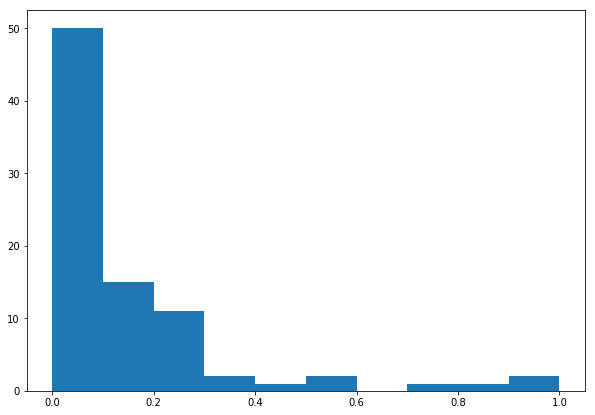

In [234]:
#generate EQ distribution
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.hist(EQ_dict.values())
plt.savefig("dist_EQ.png", format="png")